In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import itertools
%matplotlib inline

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,10

In [3]:
# using the boston home value dataset as example
# http://www.kellogg.northwestern.edu/faculty/weber/emp/_session_3/boston.htm
df = pd.read_csv('boston1.txt',sep='\t')

df.fillna(0,inplace = True)
target_field = 'MV'
df.head()

#please specific the target variable field name


,MV,INDUS,NOX,RM,TAX,PT,LSTAT
0,24.0,2.31,53.8,6.575,296,15.3,4.98
1,21.6,7.07,46.9,6.421,242,17.8,9.14
2,34.7,7.07,46.9,7.185,242,17.8,4.03
3,33.4,2.18,45.8,6.998,222,18.7,2.94
4,36.2,2.18,45.8,7.147,222,18.7,5.33


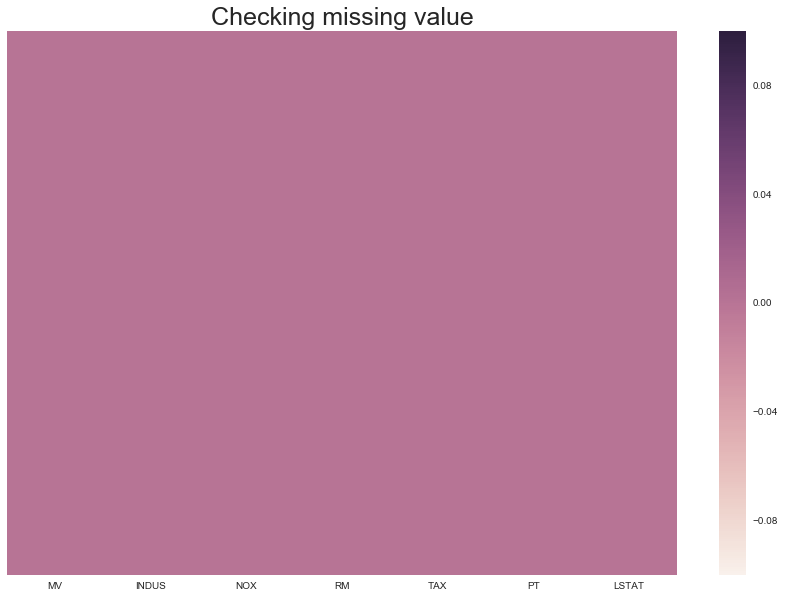

In [4]:
sns.heatmap(df.isnull(),yticklabels=False)
plt.title('Checking missing value',fontsize=25)

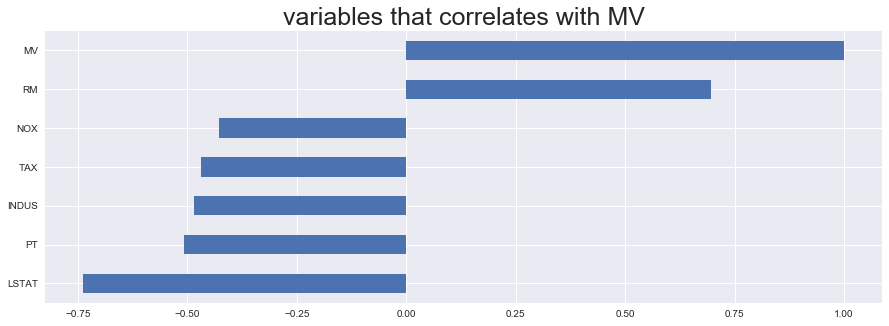

In [5]:
plt.figure(figsize=(15,5))

df.corr()[target_field].sort_values().plot(kind='barh')
plt.title('variables that correlates with '+target_field,fontsize=25)

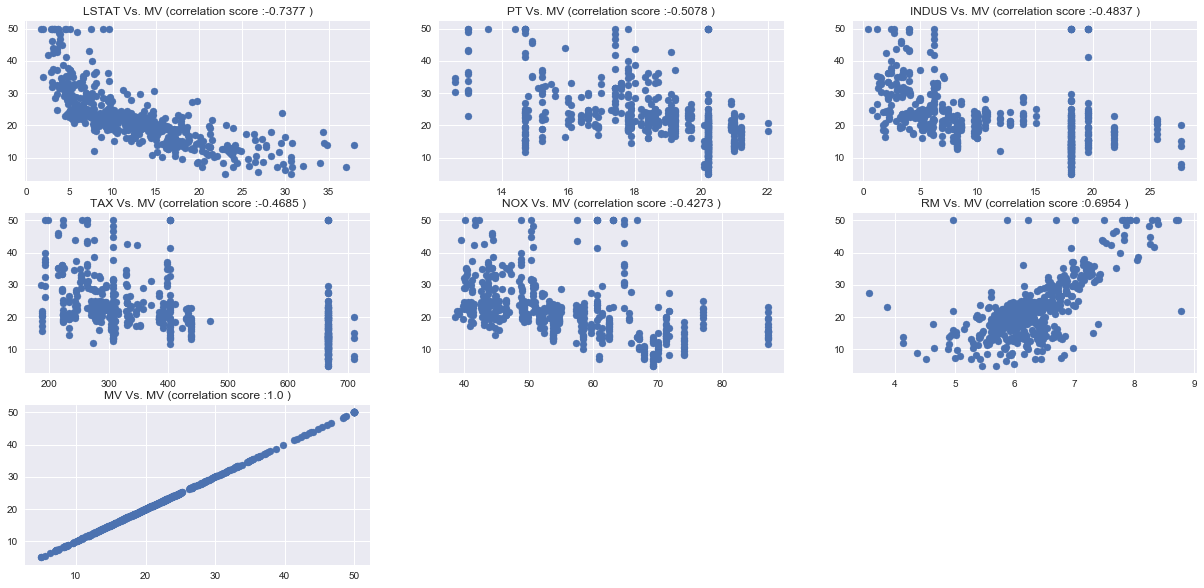

In [6]:
fig = plt.figure(figsize=(21,10))


for i,var in enumerate(list(df.corr()[target_field].sort_values().index)):
    num = '33'+str(i+1)
    sub_i = fig.add_subplot(int(num))
    sub_i.scatter(df[var],df[target_field])
    
    r2 = np.round((np.corrcoef(df[target_field],df[var])[0][1]),4)
    sub_i.xlabel = var
    sub_i.ylabel = target_field
    sub_i.set_title(var+' Vs. '+target_field+' (correlation score :'+str(r2)+' )')


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale, StandardScaler
import math
from sklearn.metrics import r2_score,mean_squared_error
from scipy import stats


C:\Users\yoonlow\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
def build_model(x_data,y_data,col):
    
    lg.fit(x_data,y_data)
    params = np.append(lg.intercept_,lg.coef_)
    predictions = lg.predict(x_data)
    
    newX = pd.DataFrame({"Constant":np.ones(len(x_data))}).join(pd.DataFrame(x_data))
    MSE = (sum((y_data-predictions)**2))/(len(newX)-len(newX.columns))
    
    
    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b
    
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-(newX.shape[1]-1)-1))) for i in ts_b]
    
    sd_b = np.round(sd_b,4)
    ts_b = np.round(ts_b,4)
    p_values = np.round(p_values,4)
    params = np.round(params,4)
    
    columns = [x for x in col if x != target_field]
    myDF = pd.DataFrame()
    myDF["variables"],myDF["Coefficients"],myDF["Standard Errors"],myDF["t values"],myDF["Probabilites"] = [np.array(['intercept']+columns),params,sd_b,ts_b,p_values]
    return myDF.sort_values(by='Probabilites')

In [9]:
def eval_model(x_data,y_data,x_test_data,y_test_data):
    clg = LinearRegression()
    clg.fit(x_data,y_data)
    lg_prediciton = clg.predict(x_test_data)
    return np.sqrt(mean_squared_error(y_test_data,lg_prediciton))


In [10]:
# include any variable that to be excluded from the model after the initial data exploration
add_list = []

# set a correlation threshold, any variable has a higher correlation percentage will be considered within the model
corr_ratio = -1

# set testing dataset ratio
test_size = 0.3

df_ps3 = df.drop(add_list,axis=1)
columns = list(df_ps3.corr()[target_field][df_ps3.corr()[target_field]>=corr_ratio].index)

print("variables are considered :")
print(columns)

lg = LinearRegression()

X_df = df_ps3[columns].drop(target_field,axis=1)
y_df = y = df_ps3[target_field]

columns = [x for x in columns if x != target_field]

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=test_size,random_state=101)

scaler = StandardScaler()

print("training dataset shape :")
print(X_train_df.shape)
print("testing dataset shape :")
print(X_test_df.shape)

result = {}
for i in range(1,len(columns)+1):
    for combo in itertools.combinations(columns,i):

        
        combo = list(combo)

        lg.fit(scaler.fit_transform(X_train_df[combo].values),y_train_df.values)
        result[",".join(combo)] = eval_model(scaler.fit_transform(X_train_df[combo].values)
                                   , y_train_df.values
                                   ,scaler.transform(X_test_df[combo].values)
                                   , y_test_df.values
                                  )
        
        
        


C:\Users\yoonlow\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


variables are considered :
['MV', 'INDUS', 'NOX', 'RM', 'TAX', 'PT', 'LSTAT']
training dataset shape :
(354, 6)
testing dataset shape :
(152, 6)


In [13]:
# setting the correlation between actual value and predicted value (training dataset) from the model
corr_coef = 0.6

# setting the variable significant threshold
p_value_threshold = 0.05

# model that is satisfied the above criteria will be outputted

for col in list(pd.DataFrame(list(result.values()),list(result.keys())).sort_values(by=0).index):
    col = col.split(',')
    
    output = build_model(scaler.fit_transform(X_train_df[col].values),y_train_df,col)
    if np.corrcoef(y_train_df,lg.predict(scaler.transform(X_train_df[col].values)))[0][1] >= corr_coef:
        if output['Probabilites'].max()<= p_value_threshold:
            print(output)
            print('***'*25)
            print('model correlation :',np.corrcoef(y_train_df,lg.predict(scaler.transform(X_train_df[col].values)))[0][1])
            print('model R2 :',np.corrcoef(y_train_df,lg.predict(scaler.transform(X_train_df[col].values)))[0][1]**2)
            print('model test data error :',result[",".join(col)])
            print('***'*25)

   variables  Coefficients  Standard Errors  t values  Probabilites
0  intercept       21.9768           0.2649   82.9668           0.0
1         RM        2.7332           0.3365    8.1220           0.0
2         PT       -2.0624           0.2925   -7.0509           0.0
3      LSTAT       -4.0747           0.3420  -11.9154           0.0
***************************************************************************
model correlation : 0.825313908266
model R2 : 0.681143047178
model test data error : 5.78087535058
***************************************************************************
   variables  Coefficients  Standard Errors  t values  Probabilites
0  intercept       21.9768           0.2799   78.5287        0.0000
1         RM        3.2155           0.3521    9.1325        0.0000
3      LSTAT       -4.0808           0.4047  -10.0837        0.0000
2        TAX       -0.9539           0.3353   -2.8452        0.0047
*********************************************************************

C:\Users\yoonlow\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [12]:
# example use of build_model function
# build the regression without transforming the data and without train_test split
col = ['RM']
build_model(df[col].values,df[target_field],col)

,variables,Coefficients,Standard Errors,t values,Probabilites
0,intercept,-34.6706,2.6498,-13.0842,0.0
1,RM,9.1021,0.4190,21.7220,0.0
